# Verificação das hipóteses relacionadas a nota média

## Verificação das hipóteses 0, 1 e 5

Hipótese 0: Se o pedido é cancelado, a nota do pedido é menor \
Hipótese 1: Se o pedido foi entregue com atraso, a nota do pedido será menor \
Hipótese 5: Se o pedido atrasar sua nota será menor que três

### Definição do dataframe

In [1]:
from pyspark.sql import SparkSession, functions as F
spark = SparkSession.builder.getOrCreate()
df_reviews = spark.read \
                 .option('escape', '\"') \
                 .csv('./dataset/olist_order_reviews_dataset.csv', header=True, multiLine=True, inferSchema=True)
df_orders = spark.read \
                 .option('escape', '\"') \
                 .csv('./dataset/olist_orders_dataset.csv', header=True, multiLine=True, inferSchema=True)
df = df_orders.join(df_reviews, df_orders.order_id == df_reviews.order_id)

In [2]:
df.printSchema()

root
 |-- order_id: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- order_status: string (nullable = true)
 |-- order_purchase_timestamp: timestamp (nullable = true)
 |-- order_approved_at: timestamp (nullable = true)
 |-- order_delivered_carrier_date: timestamp (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)
 |-- review_id: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- review_score: integer (nullable = true)
 |-- review_comment_title: string (nullable = true)
 |-- review_comment_message: string (nullable = true)
 |-- review_creation_date: timestamp (nullable = true)
 |-- review_answer_timestamp: timestamp (nullable = true)



### Calculo nota média geral

In [3]:
df.select(F.mean('review_score')).show()

+-----------------+
|avg(review_score)|
+-----------------+
|          4.07089|
+-----------------+



### Calculo nota média dos cancelados

In [4]:
df_canceled = df.filter(F.col('order_status')=='canceled')

In [5]:
df_canceled.select(F.mean('review_score')).show()

+------------------+
| avg(review_score)|
+------------------+
|1.8108108108108107|
+------------------+



## Calculo nota média dos atrasados

In [6]:
df_late = df.filter(F.col('order_delivered_customer_date') > F.col('order_estimated_delivery_date'))

In [7]:
df_late.select(F.mean('review_score')).show()

+-----------------+
|avg(review_score)|
+-----------------+
|  2.5465293668955|
+-----------------+



### Calculo de pedidos atrasados com nota maior ou igual a 3 (hipótese 5)

In [8]:
print("O numero de pedidos atrasados com nota >=3 é de",df_late.filter(F.col('review_score')>=3).count())

O numero de pedidos atrasados com nota >=3 é de 3572


In [9]:
print("Porcentagem de pedidos atrasados com nota >= 3:",
      round(df_late.filter(F.col('review_score')>=3).count() / df_late.count() * 100,2))

Porcentagem de pedidos atrasados com nota >= 3: 45.41


## Testes

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df_new = df.groupBy(F.month('order_purchase_timestamp').alias('month'),F.year('order_purchase_timestamp') \
                    .alias('year')).count() \
                    .orderBy(F.col('year'),F.col('month'))

In [12]:
from pyspark.sql import functions as sf
df_new = df_new.withColumn('month_year', 
                    sf.concat(sf.col('month'),sf.lit('/'), sf.col('year')))

df_new = df_new.selectExpr('month', 'year', 'count as demand', 'month_year')
df_new.show()

+-----+----+------+----------+
|month|year|demand|month_year|
+-----+----+------+----------+
|    9|2016|     4|    9/2016|
|   10|2016|   327|   10/2016|
|   12|2016|     1|   12/2016|
|    1|2017|   807|    1/2017|
|    2|2017|  1788|    2/2017|
|    3|2017|  2697|    3/2017|
|    4|2017|  2411|    4/2017|
|    5|2017|  3737|    5/2017|
|    6|2017|  3277|    6/2017|
|    7|2017|  4068|    7/2017|
|    8|2017|  4374|    8/2017|
|    9|2017|  4312|    9/2017|
|   10|2017|  4664|   10/2017|
|   11|2017|  7598|   11/2017|
|   12|2017|  5701|   12/2017|
|    1|2018|  7313|    1/2018|
|    2|2018|  6817|    2/2018|
|    3|2018|  7250|    3/2018|
|    4|2018|  6951|    4/2018|
|    5|2018|  6882|    5/2018|
+-----+----+------+----------+
only showing top 20 rows



In [13]:
df_new.show(50)

+-----+----+------+----------+
|month|year|demand|month_year|
+-----+----+------+----------+
|    9|2016|     4|    9/2016|
|   10|2016|   327|   10/2016|
|   12|2016|     1|   12/2016|
|    1|2017|   807|    1/2017|
|    2|2017|  1788|    2/2017|
|    3|2017|  2697|    3/2017|
|    4|2017|  2411|    4/2017|
|    5|2017|  3737|    5/2017|
|    6|2017|  3277|    6/2017|
|    7|2017|  4068|    7/2017|
|    8|2017|  4374|    8/2017|
|    9|2017|  4312|    9/2017|
|   10|2017|  4664|   10/2017|
|   11|2017|  7598|   11/2017|
|   12|2017|  5701|   12/2017|
|    1|2018|  7313|    1/2018|
|    2|2018|  6817|    2/2018|
|    3|2018|  7250|    3/2018|
|    4|2018|  6951|    4/2018|
|    5|2018|  6882|    5/2018|
|    6|2018|  6173|    6/2018|
|    7|2018|  6314|    7/2018|
|    8|2018|  6514|    8/2018|
|    9|2018|    16|    9/2018|
|   10|2018|     4|   10/2018|
+-----+----+------+----------+



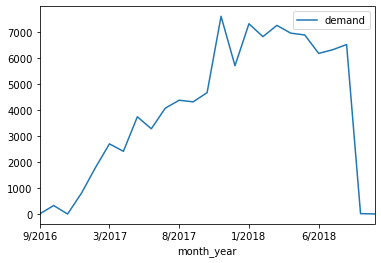

In [14]:
df_new.toPandas().plot(x ='month_year', y='demand', kind = 'line')

In [15]:
df_new_2 = df.select(F.month('order_purchase_timestamp').alias('month'),F.year('order_purchase_timestamp').alias('year'),F.col('review_score')) \
.orderBy(F.col('year'),F.col('month'))
df_new_2.show()

+-----+----+------------+
|month|year|review_score|
+-----+----+------------+
|    9|2016|           1|
|    9|2016|           1|
|    9|2016|           1|
|    9|2016|           1|
|   10|2016|           4|
|   10|2016|           3|
|   10|2016|           1|
|   10|2016|           1|
|   10|2016|           4|
|   10|2016|           5|
|   10|2016|           5|
|   10|2016|           5|
|   10|2016|           5|
|   10|2016|           5|
|   10|2016|           5|
|   10|2016|           4|
|   10|2016|           4|
|   10|2016|           1|
|   10|2016|           5|
|   10|2016|           5|
+-----+----+------------+
only showing top 20 rows



In [16]:
from pyspark.sql import functions as sf
df_new_2 = df_new_2.withColumn('month_year', 
                    sf.concat(sf.col('month'),sf.lit('/'), sf.col('year')))

In [17]:
df_new_2.show()

+-----+----+------------+----------+
|month|year|review_score|month_year|
+-----+----+------------+----------+
|    9|2016|           1|    9/2016|
|    9|2016|           1|    9/2016|
|    9|2016|           1|    9/2016|
|    9|2016|           1|    9/2016|
|   10|2016|           4|   10/2016|
|   10|2016|           3|   10/2016|
|   10|2016|           1|   10/2016|
|   10|2016|           1|   10/2016|
|   10|2016|           4|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           4|   10/2016|
|   10|2016|           4|   10/2016|
|   10|2016|           1|   10/2016|
|   10|2016|           5|   10/2016|
|   10|2016|           5|   10/2016|
+-----+----+------------+----------+
only showing top 20 rows



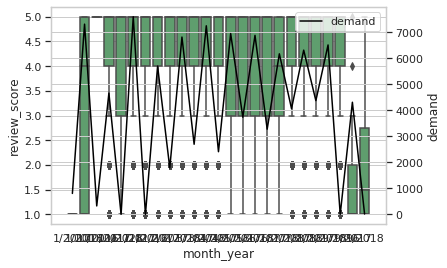

In [18]:
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")
ax = sns.boxplot(x='month_year', y='review_score',color="g", data=df_new_2.toPandas())
ax2 = ax.twinx()
ax2 = sns.lineplot(x='month_year', y='demand',color='.0', label='demand',  data=df_new.toPandas())

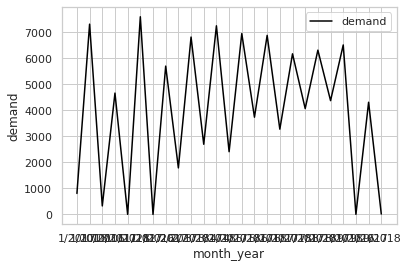

In [19]:
ax2 = sns.lineplot(x='month_year', y='demand',color='.0', label='demand',  data=df_new.toPandas())

## Conclusões

### A hipótese 0 é válida, pois a média das notas de todos os pedidos é maior que a média das notas dos pedidos cancelados

### A hipótese 1 é válida, pois a média das notas de todos os pedidos é maior que a média das notas dos pedidos cancelados

### A hipótese 5 é inválida pois existem pedidos atrasados que possuem nota maior ou igual a 3, são 3572 pedidos com essas características